<a href="https://colab.research.google.com/github/subodhkhanger/Snapchatlenses_Clone/blob/master/faceDectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict
from torch.optim import lr_scheduler

In [27]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x587a8000 @  0x7f86f36702a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

user = "subodhkhanger"
key ="4699d99eb9880f95d1a22b847a681b80"

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c facial-keypoints-detection

 72% 43.0M/60.1M [00:00<00:00, 48.6MB/s]
100% 60.1M/60.1M [00:00<00:00, 122MB/s] 
 31% 5.00M/16.0M [00:00<00:00, 32.7MB/s]
100% 16.0M/16.0M [00:00<00:00, 62.9MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 68.1MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 119MB/s]


In [0]:
!unzip -qq training.zip
!unzip -qq test.zip

In [0]:
df = pd.read_csv('./training.csv')

In [0]:
df.tail()

In [16]:
df.shape

(7049, 31)

In [0]:
def string2image(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, ax in zip(image_strings, axes.ravel()):
        ax.imshow(string2image(string), cmap='gray')
        ax.axis('off')

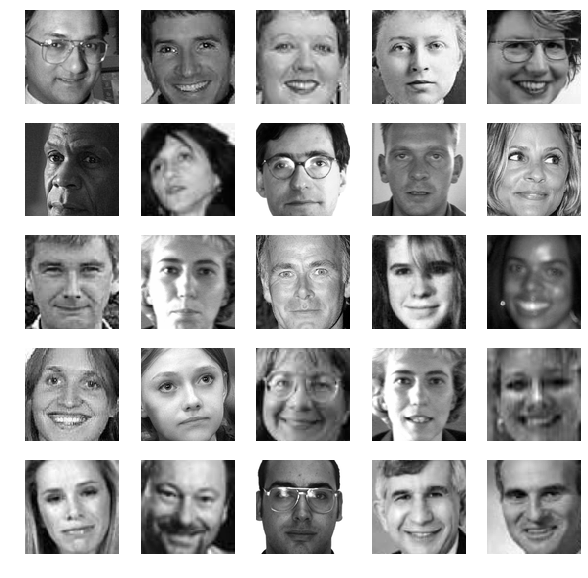

In [18]:
plot_faces()

In [0]:
keypoint_cols = list(df.columns)[:-1]

In [20]:
#first row/image's keypoints
xy = df.iloc[1][keypoint_cols].values.reshape((15, 2))
xy 

array([[64.3329361702, 34.9700765957],
       [29.949276595700002, 33.4487148936],
       [58.856170212799995, 35.2743489362],
       [70.7227234043, 36.1871659574],
       [36.034723404299996, 34.3615319149],
       [24.472510638299998, 33.1444425532],
       [53.9874042553, 28.2759489362],
       [78.634212766, 30.405923404299998],
       [42.7288510638, 26.1460425532],
       [16.8653617021, 27.058859574499998],
       [48.2062978723, 55.6609361702],
       [56.4214468085, 76.352],
       [35.122382978699996, 76.0476595745],
       [46.684595744700005, 70.2665531915],
       [45.467914893599996, 85.48017021279999]], dtype=object)

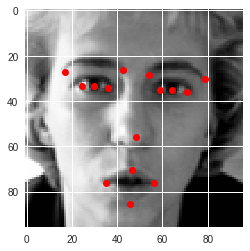

In [21]:
plt.plot(xy[:, 0], xy[:, 1], 'ro')
plt.imshow(string2image(df.iloc[1]['Image']), cmap='gray')

In [22]:
fully_annotated = df.dropna()
fully_annotated.shape

(2140, 31)

In [0]:
X = np.stack([string2image(string) for string in fully_annotated['Image']]).astype(np.float)[:, :, :, np.newaxis]

In [0]:
y = np.vstack(fully_annotated[fully_annotated.columns[:-1]].values)

In [0]:
dataloaders = { torch.utils.data.DataLoader(X, batch_size=64, shuffle=True)}

In [0]:
data_transforms = {transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomRotation(degrees=90),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], 
                                                         [0.5, 0.5, 0.5])])}


# TODO: Load the datasets with ImageFolder
image_datasets = {datasets.ImageFolder(X, transform=data_transforms)
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'training' : torch.utils.data.DataLoader(image_datasets['training'], batch_size=64, shuffle=True),
    'validation' : torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64, shuffle=True)
}

class_to_idx = image_datasets['training'].class_to_idx

AttributeError: ignored